# Example use-case: cross-match ZTF BTS and NGC

Here we demonstrate how to cross-match [Zwicky Transient Facility](https://ztf.caltech.edu) (ZTF) [Bright Transient Survey](https://sites.astro.caltech.edu/ztf/bts) (BTS) and [New General Catalogue](https://en.wikipedia.org/wiki/New_General_Catalogue) (NGC) using LSDB.

In [1]:
# Install astroquery, comment this line if you already have it
!pip install --quiet astroquery

In [2]:
import lsdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.vizier import Vizier
from dask.distributed import Client

### Download ZTF BTS and convert coordinates to degrees

In [3]:
%%time

df_ztf_bts = pd.read_csv(
    "http://sites.astro.caltech.edu/ztf/bts/explorer.php?format=csv",
    na_values="-",
)
coord = SkyCoord(df_ztf_bts["RA"], df_ztf_bts["Dec"], unit=("hourangle", "deg"))
df_ztf_bts["ra_deg"], df_ztf_bts["dec_deg"] = coord.ra.deg, coord.dec.deg
df_ztf_bts.head()

CPU times: user 1.13 s, sys: 12.1 ms, total: 1.14 s
Wall time: 3.37 s


,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V,ra_deg,dec_deg
0,ZTF20acglhmi,AT2020usb,21:05:10.27,-09:32:41.6,1125.77,r,18.8811,NaN,26.434,8.525,17.909,NaN,NaN,-33.998743,0.313,316.292792,-9.544889
1,ZTF21acipofv,SN2017baq,08:58:47.64,+01:50:34.5,1518.95,g,18.6062,-18.56,22.505,11.455,11.05,SN Ia,0.05814,28.941824,0.122,134.698500,1.842917
2,ZTF20aakyqlh,SN2017bde,12:29:07.58,+36:27:24.1,2056.78,g,18.2972,-19.20,>21.03,>10.02,>11.01,SN Ia,0.07138,79.541246,0.029,187.281583,36.456694
3,ZTF19acdgwhq,SN2017gcd,02:56:08.46,+15:12:47.0,785.79,r,17.7568,-17.95,23.202,11.519,11.683,SN Ia,0.02859,-37.960566,0.294,44.035250,15.213056
4,ZTF18acxgqij,AT2017hio,23:02:37.73,+41:05:30.6,1679.01,r,18.5201,NaN,>8.732,7.722,>1.01,NaN,NaN,-17.268768,0.305,345.657208,41.091833


### Download NGC with `astroquery`

Please install astroquery first with `pip install astroquery` or `conda install -c conda-forge astroquery`.

In [4]:
%%time

vizier = Vizier(row_limit=50_000)
tables = vizier.get_catalogs("VII/118/ngc2000")
df_ngc = tables[0].to_pandas()
coord = SkyCoord(df_ngc["RAB2000"], df_ngc["DEB2000"], unit=("hourangle", "deg"))
df_ngc["ra_deg"], df_ngc["dec_deg"] = coord.ra.deg, coord.dec.deg
df_ngc.head()

CPU times: user 1.62 s, sys: 16.3 ms, total: 1.64 s
Wall time: 2.92 s


,Name,Type,RAB2000,DEB2000,Source,Const,l_size,size,mag,n_mag,Desc,ra_deg,dec_deg
0,I5370,Gx,00 00.1,+32 45,m,And,,0.7,15.0,p,"pB, S, R, stell N",0.025,32.750000
1,I5371,,00 00.2,+32 49,d,And,,NaN,NaN,,"F, vS, *15 att",0.050,32.816667
2,7801,-,00 00.4,+50 42,r,Cas,,NaN,NaN,,"Cl, pRi, pC, st 9...",0.100,50.700000
3,I5372,Gx,00 00.4,+32 47,m,And,,0.7,15.0,p,"F, vS, R N",0.100,32.783333
4,I5373,Gx,00 00.4,+32 47,m,And,,0.7,15.0,p,"pB, S, R, stell N",0.100,32.783333


### Put both catalogs to LSDB and plan cross-match

Of course ZTF looks much deeper than NGC galaxies from 19th century, so we filter ZTF transients by redshift.

LSDB is built upon [Dask](https://dask.org) and can be used with Dask distributed cluster. In this cell we just plan computations and do not actually run them.

In [5]:
%%time

ztf_bts = lsdb.from_dataframe(df_ztf_bts, ra_column="ra_deg", dec_column="dec_deg")
ngc = lsdb.from_dataframe(df_ngc, ra_column="ra_deg", dec_column="dec_deg", margin_threshold=3600)

ztf_bts = ztf_bts.query("redshift < 0.01")

matched = ztf_bts.crossmatch(ngc, radius_arcsec=1200, suffixes=("_ztf", "_ngc"))
matched

CPU times: user 32.8 s, sys: 33.1 ms, total: 32.8 s
Wall time: 32.9 s


,ZTFID_ztf,IAUID_ztf,RA_ztf,Dec_ztf,peakt_ztf,peakfilt_ztf,peakmag_ztf,peakabs_ztf,duration_ztf,rise_ztf,fade_ztf,type_ztf,redshift_ztf,b_ztf,A_V_ztf,ra_deg_ztf,dec_deg_ztf,Norder_ztf,Dir_ztf,Npix_ztf,Name_ngc,Type_ngc,RAB2000_ngc,DEB2000_ngc,Source_ngc,Const_ngc,l_size_ngc,size_ngc,mag_ngc,n_mag_ngc,Desc_ngc,ra_deg_ngc,dec_deg_ngc,Norder_ngc,Dir_ngc,Npix_ngc,_dist_arcsec
npartitions=12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],double[pyarrow]
288230376151711744,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170534137668829184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458764513820540928,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Run LSDB pipeline

In [6]:
%%time

# Create default local cluster
with Client():
    matched_df = matched.compute()

# Let's output transient name, NGC name and angular distance between them
matched_df = matched_df[["IAUID_ztf", "Name_ngc", "_dist_arcsec", "RA_ztf", "Dec_ztf"]].sort_values(
    by=["_dist_arcsec"]
)
matched_df

CPU times: user 1.47 s, sys: 128 ms, total: 1.6 s
Wall time: 7.74 s


,IAUID_ztf,Name_ngc,_dist_arcsec,RA_ztf,Dec_ztf
_healpix_29,,,,,
1957242016251976064,SN2022xxf,3705,2.985601,11:30:05.93,+09:16:57.2
1827616204711960889,SN2024jlf,5690,6.309787,14:37:42.32,+02:17:04.1
1800033011516991717,SN2020vg,I 738,8.93114,11:48:54.43,-04:40:53.8
807865178253637450,SN2022pgf,5894,12.223285,15:11:41.90,+59:49:12.2
539016490002576270,SN2021do,3147,14.058304,10:16:56.52,+73:23:51.0
...,...,...,...,...,...
184575816002918654,AT2020tvc,221,762.96003,00:41:35.40,+40:50:14.6
1950510475429997504,SN2021hiz,I 789,963.643556,12:25:41.67,+07:13:42.2
790432597246972897,SN2018hna,4362,964.142774,12:26:12.08,+58:18:50.8


We may have some false matches here, because NGC is too shallow for this task. However, if we sort the table by the cross-match distance, we can see the first one is a supernova ([SN2022xxf](https://www.wis-tns.org/object/2022xxf)) in the nearby galaxy NGC 3705.

### Make some plot

This part is not related to LSDB and adopted from [PanSTARRS image this tutorial](https://spacetelescope.github.io/mast_notebooks/notebooks/PanSTARRS/PS1_image/PS1_image.html).

Now let's download host galaxy image from the PanSTARRS survey and plot it out (with SN location in the middle and marked with a "+" 

In [7]:
def getimages(ra, dec, size=240, filters="grizy"):
    """Query ps1filenames.py service to get a list of images

    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """

    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits" "&filters={filters}").format(**locals())
    table = Table.read(url, format="ascii")
    return table


def get_ps1_image(url, size=240):
    """
    size: pixel number for 0.25 arcsec/pixel
    """
    from PIL import Image
    import requests
    from io import BytesIO

    try:
        r = requests.get(url)
        im = Image.open(BytesIO(r.content))
    except:
        print("Can't get ps1 image")
        im = None
    return im

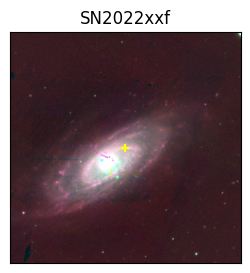

In [8]:
c = SkyCoord(
    matched_df["RA_ztf"].to_numpy()[0], matched_df["Dec_ztf"].to_numpy()[0], unit=("hourangle", "deg")
)
ra = c.ra.degree
dec = c.dec.degree
oid = matched_df["IAUID_ztf"].to_numpy()[0]
table = getimages(ra, dec, size=1200, filters="grizy")
url = (
    "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
    "ra={}&dec={}&size=1200&format=jpg&red={}&green={}&blue={}"
).format(ra, dec, table["filename"][0], table["filename"][1], table["filename"][2])
im = get_ps1_image(url)
fig, ax = plt.subplots(figsize=(7, 3))
if im is not None:
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(np.average(plt.xlim()), np.average(plt.ylim()), marker="+", color="yellow")
    ax.set_title(oid)
    plt.show()